# Amazon Fine Food Review Analysis using SVM

In [2]:
%matplotlib inline

import sqlite3
import pandas as pd
import seaborn as sn
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn import linear_model
import warnings
warnings.filterwarnings("ignore")

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('final.sqlite') 

In [4]:
data = pd.read_sql_query("""SELECT * FROM Reviews""", con)
labels_count = data['Score'].value_counts()
#labels = sorted_data['Score']
print(labels_count)

positive    307061
negative     57110
Name: Score, dtype: int64


In [5]:
# TIme based sorting
sorted_data=data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
labels = sorted_data['Score']
print(labels.shape)
print(sorted_data.shape)

(364171,)
(364171, 12)


In [6]:
sorted_data.head()         # Time is in ascending order which means the dataset is of Time Based slicing.

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


In [7]:
sorted_data['CleanedText'][0]

b'witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg'

# Bag of Words

In [9]:
sample_data = sorted_data.sample(n=100000)
print(sample_data.shape)
sample_labels = sample_data['Score']
print(sample_labels.shape)

(100000, 12)
(100000,)


In [10]:
sample_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
268555,346760,375104,B003CG16OS,AR3Q8CIM1S4JW,J. C. Provenz,0,0,positive,1335052800,Yum!!!,"I love this baby food. I'd eat it. Its safe,...",b'love babi food eat safe healthi simpl ingred...
2161,17116,18669,B00008JOL0,AS5VIFYZBZTSA,3chis&amp;adobe,0,0,positive,1346716800,Great product,I thought I would try these as a last attempt ...,b'thought would tri last attempt get dog take ...
173243,22358,24472,B001E96JYC,A3BH49ZKESHDID,Fred Camfield,0,0,positive,1310947200,Quick microwave meal,"Not quite as good as Chinese takeout, but it h...",b'quit good chines takeout conveni keep desk d...
133378,285318,309089,B000YPA73Q,A7YD7EDTU21UH,Pugsley,0,1,negative,1313366400,Horrible!!!!!!!!!!,I had a coupon for this water and Kroger had i...,b'coupon water kroger sale bought absolut wors...
219015,262830,284907,B001UUB8WS,AX56F4VSV3FU4,"Nancy J ""NJ""",0,0,positive,1344470400,CoffeeMate is my standard,I prefer CoffeeMate to any other creamer. I bu...,b'prefer coffeem creamer buy individu packet c...


# Train, CV and Test -  BOW

In [21]:
# split the data set into train and test
X_tr, X_test, y_tr, y_test = cross_validation.train_test_split(sample_data['Text'], sample_labels, test_size=0.2, random_state=0)

In [24]:
# BOW on train data

count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(X_tr.values)
f_c = count_vect.transform(X_tr.values)

In [28]:
# Standardization of train data
X_tr_standardized_data = StandardScaler(with_mean=False).fit_transform(f_c)
print(X_tr_standardized_data.shape)

(80000, 55369)


In [31]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores = []
for val in C_Val:
    svc_reg = linear_model.SGDClassifier(loss='hinge',alpha=val,n_jobs=-1)
    scores = cross_val_score(svc_reg, X_tr_standardized_data, y_tr, cv=3, scoring='accuracy')
    cv_scores.append(scores.mean())
print(cv_scores)

[0.88537498058893715, 0.89011246590273396, 0.91014999950316566, 0.90148750840682002, 0.84418750088881966, 0.84333750026354626, 0.84333750026354626]


In [35]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
# determining best lambda
optimal_lambda = C_Val[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is %f.' % optimal_lambda)


The optimal number of alpha is 0.100000.


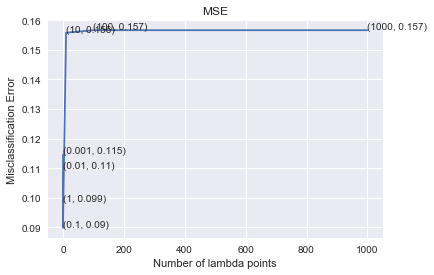

the misclassification error for each alpha is :  [ 0.115  0.11   0.09   0.099  0.156  0.157  0.157]


In [36]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE)

for xy in zip(C_Val, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of lambda points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE,3))

In [34]:
# Applying the vectors of train data on the test data

final_counts_x_test = count_vect.transform(X_test.values)
standardized_data_X_test = StandardScaler(with_mean=False).fit_transform(final_counts_x_test)
print(standardized_data_X_test.shape)

(20000, 55369)


In [43]:
# instantiate learning model k = optimal_k
svc_reg_optimal = linear_model.SGDClassifier(loss='hinge',alpha=optimal_lambda,n_jobs=-1)

# fitting the model
svc_reg_optimal.fit(X_tr_standardized_data, y_tr)

# predict the response
pred = svc_reg_optimal.predict(standardized_data_X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the SGD Classifier with hinge loss for alpha = %f is %f%%' % (optimal_lambda, acc))


The accuracy of the SGD Classifier with hinge loss for alpha = 0.100000 is 91.405000%


In [45]:
from sklearn.svm import SVC
svc_bow = SVC(C=optimal_lambda)
# fitting the model
svc_bow.fit(X_tr_standardized_data, y_tr)
# predict the response
pred = svc_bow.predict(standardized_data_X_test)
# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the SVC for C = %f is %f%%' % (optimal_lambda, acc))


The accuracy of the SVC for C = 0.100000 is 84.610000%


# GridSearch - BOW

In [38]:
# As per the documentation of SGD classifier, here alpha value multiplies the regularization term 
# and also used to compute learning_rate when set to ‘optimal’.
# Therefore one value(alpha) is sufficient and is equivalent to C and gamma in SVC classifier
from sklearn.grid_search import GridSearchCV
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model = GridSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model.fit(X_tr_standardized_data, y_tr)
print(model.best_estimator_)

SGDClassifier(alpha=1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [39]:
print(model.score(standardized_data_X_test, y_test))

0.903


# RandomSearchCV BOW

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'alpha': uniform.rvs(size=10)}
model_rand_l2 = RandomizedSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2.fit(X_tr_standardized_data, y_tr)
print(model_rand_l2.best_estimator_)

SGDClassifier(alpha=0.16448503340911746, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [41]:
print(model_rand_l2.score(standardized_data_X_test, y_test))

0.9161


# TF-IDF

# Train,Test,CV

In [47]:
# split the data set into train and test
X_tr_tf, X_test_tf, y_tr_tf, y_test_tf = cross_validation.train_test_split(sample_data['Text'], sample_labels, test_size=0.2, random_state=0)
# split the train data set into cross validation train and cross validation test
# X_tr_tf, X_cv_tf, y_tr_tf, y_cv_tf = cross_validation.train_test_split(X_1_tf, y_1_tf, test_size=0.3)

In [48]:
# TF-IDF on train data
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_vect.fit(X_tr_tf.values)
final_tf_idf = tf_idf_vect.transform(X_tr_tf.values)

In [49]:
# Standardization of train data
X_tr_standardized_data_tf = StandardScaler(with_mean=False).fit_transform(final_tf_idf)
print(X_tr_standardized_data_tf.shape)

(80000, 1106401)


In [50]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores_tf_idf = []
for val in C_Val:
    svc_reg_tf_idf = linear_model.SGDClassifier(loss='hinge',alpha=val,n_jobs=-1)
    scores_tf = cross_val_score(svc_reg_tf_idf, X_tr_standardized_data_tf, y_tr_tf, cv=3, scoring='accuracy')
    cv_scores_tf_idf.append(scores_tf.mean())
print(cv_scores_tf_idf)

[0.8977374765302496, 0.89892497528060511, 0.90541248887655235, 0.8957375005924253, 0.86498748933267533, 0.84335000057605403, 0.84333750026354626]


In [52]:
# changing to misclassification error
MSE_tf = [1 - x for x in cv_scores_tf_idf]

# determining best k
optimal_aplha_tf = C_Val[MSE_tf.index(min(MSE_tf))]
print('\nThe optimal number of alpha is %f.' % optimal_aplha_tf)


The optimal number of alpha is 0.100000.


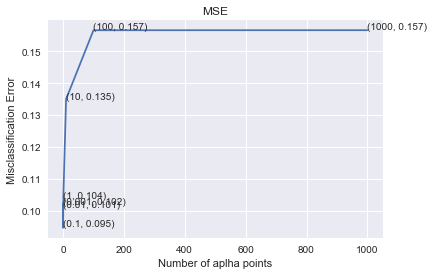

the misclassification error for each alpha is :  [ 0.102  0.101  0.095  0.104  0.135  0.157  0.157]


In [53]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE_tf)

for xy in zip(C_Val, np.round(MSE_tf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE_tf,3))

In [56]:
# Applying the vectors of train data on the test data

final_counts_x_test = tf_idf_vect.transform(X_test_tf.values)
standardized_data_X_test_tf = StandardScaler(with_mean=False).fit_transform(final_counts_x_test)
print(standardized_data_X_test_tf.shape)

(20000, 1106401)


In [57]:
# instantiate learning model k = optimal_k
svc_reg_optimal_tf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_aplha_tf,n_jobs=-1)

# fitting the model
svc_reg_optimal_tf.fit(X_tr_standardized_data_tf, y_tr_tf)

# predict the response
pred_tf = svc_reg_optimal_tf.predict(standardized_data_X_test_tf)

# evaluate accuracy
acc_tf = accuracy_score(y_test_tf, pred_tf) * 100
print('\nThe accuracy of the SGD with hinge loss for alpha = %f is %f%%' % (optimal_aplha_tf, acc_tf))


The accuracy of the SGD with hinge loss for alpha = 0.100000 is 91.380000%


# GridSearch TF-IDF

In [58]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_tf = GridSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_tf.fit(X_tr_standardized_data_tf, y_tr_tf)
print(model_tf.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [59]:
print(model_tf.score(standardized_data_X_test_tf, y_test_tf))

0.90545


# RandomSearchCV TF-IDF

In [60]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'alpha': uniform.rvs(size=10)}
model_rand_l2_tf = RandomizedSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2_tf.fit(X_tr_standardized_data_tf, y_tr_tf)
print(model_rand_l2_tf.best_estimator_)

SGDClassifier(alpha=0.30979510641074892, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [61]:
print(model_rand_l2_tf.score(standardized_data_X_test_tf, y_test_tf))

0.92015


# W2V

In [62]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
print(model)

In [63]:
model.wv.similarity('woman', 'man')

0.76640123

In [64]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [65]:
# Train your own Word2Vec model using your own text corpus
import gensim
i=0
list_of_sent=[]
for sent in sample_data['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
print(len(list_of_sent))

100000


In [66]:
print(sample_data['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

I love this baby food.  I'd eat it.  Its safe, healthy, simple ingredients - just blueberries and apples.  Baby loves too.  And the packaging makes it easy to transport
*****************************************************************
['i', 'love', 'this', 'baby', 'food', 'id', 'eat', 'it', 'its', 'safe', 'healthy', 'simple', 'ingredients', 'just', 'blueberries', 'and', 'apples', 'baby', 'loves', 'too', 'and', 'the', 'packaging', 'makes', 'it', 'easy', 'to', 'transport']


In [67]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
type(w2v_model)

gensim.models.word2vec.Word2Vec

In [68]:
words = list(w2v_model.wv.vocab)
print(len(words))

19121


# Average W2V

In [84]:
def create_features(list_of_sent):
    # average Word2Vec
    # compute average word2vec for each review.
    sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0 # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return sent_vectors

# Train,CV,Test - AvgW2V

In [69]:
# split the data set into train and test
X_tr_w2v, X_test_w2v, y_tr_w2v, y_test_w2v = cross_validation.train_test_split(list_of_sent, sample_labels, test_size=0.2, random_state=0)

# split the train data set into cross validation train and cross validation test
X_tr_w2v, X_cv_w2v, y_tr_w2v, y_cv_w2v = cross_validation.train_test_split(X_1_w2v, y_1_w2v, test_size=0.2)

In [82]:
# Applying the vectorizations on train data
sent_vectors_x_tr_df = create_features(X_tr_w2v)

In [75]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores_w2v = []
for val in C_Val:
    svc_reg_w2v = linear_model.SGDClassifier(loss='hinge',alpha=val,n_jobs=-1)
    scores_w2v = cross_val_score(svc_reg_w2v, sent_vectors_x_tr_df, y_tr_w2v, cv=3, scoring='accuracy')
    cv_scores_w2v.append(scores_w2v.mean())
print(cv_scores_w2v)

[0.84333750026354626, 0.84333750026354626, 0.84333750026354626, 0.84333750026354626, 0.84333750026354626, 0.84333750026354626, 0.84333750026354626]


In [76]:
# changing to misclassification error
MSE_w2v = [1 - x for x in cv_scores_w2v]

# determining best k
optimal_aplha_w2v = C_Val[MSE_w2v.index(min(MSE_w2v))]
print('\nThe optimal number of alpha is %f.' % optimal_aplha_w2v)


The optimal number of alpha is 0.001000.


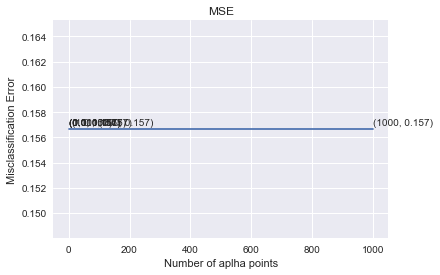

the misclassification error for each alpha is :  [ 0.157  0.157  0.157  0.157  0.157  0.157  0.157]


In [77]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE_w2v)

for xy in zip(C_Val, np.round(MSE_w2v,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE_w2v,3))

In [81]:
sent_vectors_x_test_df = create_features(X_test_w2v) # Applying the vectorizations on test data

svc_reg_optimal_w2v = linear_model.SGDClassifier(loss='hinge',alpha=optimal_aplha_w2v,n_jobs=-1) # instantiate learning model k = optimal_k

# fitting the model
svc_reg_optimal_w2v.fit(sent_vectors_x_tr_df, y_tr_w2v)

# predict the response
pred_w2v = svc_reg_optimal_w2v.predict(sent_vectors_x_test_df)

# evaluate accuracy
acc_w2v = accuracy_score(y_test_w2v, pred_w2v) * 100
print('\nThe accuracy of the SGD with hinge loss for C = %f is %f%%' % (optimal_aplha_w2v, acc_w2v))


The accuracy of the SGD with hinge loss for C = 0.001000 is 84.610000%


# GridSearch Avg W2V

In [85]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_w2v_l2 = GridSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_w2v_l2.fit(sent_vectors_x_tr_df, y_tr_w2v)
print(model_w2v_l2.best_estimator_)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [87]:
print(model_w2v_l2.score(sent_vectors_x_test_df, y_test_w2v))

0.8461


# RandomSearchCV Avg W2V

In [88]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'alpha': uniform.rvs(size=10)}
model_rand_l2_w2v = RandomizedSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2_w2v.fit(sent_vectors_x_tr_df, y_tr_w2v)
print(model_rand_l2_w2v.best_estimator_)

SGDClassifier(alpha=0.42469348089825343, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [89]:
print(model_rand_l2_w2v.score(sent_vectors_x_test_df, y_test_w2v))

0.8461


# Avg TF-IDF

In [21]:
def create_features_tfidf(_list):
    # TF-IDF weighted Word2Vec
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in _list: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            try:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
                tfidf = final_tf_idf[row, tfidf_feat.index(word)]
                sent_vec = sent_vec + (vec * tfidf)
                weight_sum = weight_sum + tfidf
            except:
                pass
        sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return tfidf_sent_vectors

In [22]:
print(tfidf_sent_vectors[0])

[ 0.1756306   0.69692612  0.08762204 -0.35830659 -0.55909844  0.17582064
 -0.43116279 -0.05661697  0.06295889  0.10089796 -0.21429689  0.29259416
 -0.38610196 -0.02007107  0.72979774 -0.10237062  0.84388899  0.08463709
  0.34623604 -0.36628136  0.16881919  0.32137898 -0.46955014 -0.21723684
 -0.18011148  0.87924615 -0.11992223  0.14479833 -0.72088958 -0.1736038
  0.12333141  0.88541261 -0.26321695  0.18994207  0.35951235  0.27374897
 -0.06206582  0.22450838 -0.09168883 -0.02519022  0.23962953  0.53806902
 -0.0834373   0.07910254 -0.20000786 -0.02653607  0.26397292  0.24843445
  0.28820519 -0.10636187]


# Train,CV,Test - AvgTF-IDF

In [97]:
# split the data set into train and test
X_1_avg_tf, X_test_avg_tf, y_1_avg_tf, y_test_avg_tf = cross_validation.train_test_split(list_of_sent, sample_labels, test_size=0.3, random_state=0)


# split the train data set into cross validation train and cross validation test
X_tr_avg_tf, X_cv_avg_tf, y_tr_avg_tf, y_cv_avg_tf = cross_validation.train_test_split(X_1_avg_tf, y_1_avg_tf, test_size=0.3)

In [126]:
# Applying weighted w2v tf-idf vectorziations on train data
sent_vectors_x_tr_avg_tf = create_features_tfidf(X_tr_avg_tf)

In [106]:
C_Val = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv_scores_avg_tf = []
for val in C_Val:
    svc_reg_avg_tf = linear_model.SGDClassifier(loss='hinge',alpha=val,n_jobs=-1)
    scores_avg_tf = cross_val_score(svc_reg_avg_tf,sent_vectors_x_tr_avg_tf, y_tr_avg_tf, cv=3, scoring='accuracy')
    cv_scores_avg_tf.append(scores_avg_tf.mean())
print(cv_scores_avg_tf)

[0.84391836305208134, 0.84412244884975074, 0.84412244884975074, 0.84412244884975074, 0.84412244884975074, 0.84412244884975074, 0.84412244884975074]


In [107]:
# changing to misclassification error
MSE_avg_tf = [1 - x for x in cv_scores_avg_tf]

# determining best k
optimal_aplha_avg_tf = C_Val[MSE_avg_tf.index(min(MSE_avg_tf))]
print('\nThe optimal number of alpha is %f.' % optimal_aplha_avg_tf)


The optimal number of alpha is 0.010000.


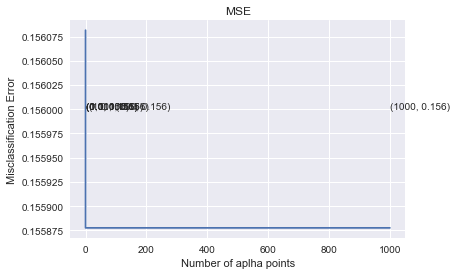

the misclassification error for each alpha is :  [ 0.156  0.156  0.156  0.156  0.156  0.156  0.156]


In [108]:
# plot misclassification error vs alpha 
plt.plot(C_Val, MSE_avg_tf)

for xy in zip(C_Val, np.round(MSE_avg_tf,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of aplha points')
plt.ylabel('Misclassification Error')
plt.title('MSE')
plt.show()

print("the misclassification error for each alpha is : ", np.round(MSE_avg_tf,3))

In [119]:
sent_vectors_x_test_avg_tf = create_features_tfidf(X_test_w2v) # Applying weighted w2v tf-idf vectorziations on test data

# instantiate learning model k = optimal_k
svc_reg_optimal_tf = linear_model.SGDClassifier(loss='hinge',alpha=optimal_aplha_avg_tf,n_jobs=-1)

# fitting the model
svc_reg_optimal_tf.fit(sent_vectors_x_tr_avg_tf, y_tr_avg_tf)

# predict the response
pred_avg_tf = svc_reg_optimal_tf.predict(sent_vectors_x_test_avg_tf)

# evaluate accuracy
acc_avg_tf = accuracy_score(y_test_avg_tf, pred_avg_tf) * 100
print('\nThe accuracy of the SGD with hinge loss for C = %f is %f%%' % (optimal_aplha_avg_tf, acc_avg_tf))


The accuracy of the SGD with hinge loss for C = 0.010000 is 84.353333%


# GridSearch Avg TF-IDF

In [113]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'alpha': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
model_avg_tf_l2 = GridSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_avg_tf_l2.fit(sent_vectors_x_tr_avg_tf, y_tr_avg_tf)
print(model_avg_tf_l2.best_estimator_)

SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [114]:
print(model_avg_tf_l2.score(sent_vectors_x_test_avg_tf, y_test_avg_tf))

0.843533333333


# RandomSearchCV AVG TF-IDF

In [115]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
tuned_parameters = {'alpha': uniform.rvs(size=10)}
model_rand_l2_avg_tf = RandomizedSearchCV(linear_model.SGDClassifier(loss='hinge',n_jobs=-1), tuned_parameters, scoring = 'accuracy', cv=5)
model_rand_l2_avg_tf.fit(sent_vectors_x_tr_avg_tf, y_tr_avg_tf)
print(model_rand_l2_avg_tf.best_estimator_)

SGDClassifier(alpha=0.51414508718348462, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)


In [116]:
print(model_rand_l2_avg_tf.score(sent_vectors_x_test_avg_tf, y_test_avg_tf))

0.843533333333


In [125]:
from ipywidgets import *
df = pd.DataFrame({"AA-features":["BOW","TF-IDF","Avg-W2V","Avg-TFIDF"],"Alpha-Accuracy-Error":["0.100000-91.4%-8.6%","0.1-91.38%-8.7%","0.001-84.6%-13.4%","0.01,84.35%,15.65%"], "GridSearch Alpha - Accuracy - Error":["1-90.3%-9.7%","0.01-90.5%-9.5%","0.0001-84.6%-13.4%","0.01-84.35%-15.65%"], "RandomSearch Alpha - Accuracy - Error":["0.16-91.61%-8.4%","0.38-92%-8%","0.42-84.6%-13.4%","0.51-84.35%-15.65%"]})
df

,AA-features,Alpha-Accuracy-Error,GridSearch Alpha - Accuracy - Error,RandomSearch Alpha - Accuracy - Error
0,BOW,0.100000-91.4%-8.6%,1-90.3%-9.7%,0.16-91.61%-8.4%
1,TF-IDF,0.1-91.38%-8.7%,0.01-90.5%-9.5%,0.38-92%-8%
2,Avg-W2V,0.001-84.6%-13.4%,0.0001-84.6%-13.4%,0.42-84.6%-13.4%
3,Avg-TFIDF,"0.01,84.35%,15.65%",0.01-84.35%-15.65%,0.51-84.35%-15.65%
